### Import packages

In [31]:
import sys
import pandas as pd
print(pd.__version__)
import os
import torch as th
print(th.backends.mps.is_available())
import numpy as np
import gymnasium as gym
print(gym.__version__)
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed

from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta

print(MAX_AIRCRAFT)
import warnings

from stable_baselines3.common.utils import polyak_update
from stable_baselines3.common.logger import configure  # Import the configure function


import stable_baselines3
print(stable_baselines3.__version__)


import stable_baselines3

import gym
print("Stable Baselines3 version:", stable_baselines3.__version__)
print("Gym version:", gym.__version__)



2.2.2
True
0.29.1
6
2.3.2
Stable Baselines3 version: 2.3.2
Gym version: 0.26.2


In [32]:
# Setting all debugging flags to False
DEBUG_MODE = False 
DEBUG_MODE_TRAINING = False 
DEBUG_MODE_REWARD = False  


### Hyperparameters

In [33]:
# Training Settings
LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 50000*2
BATCH_SIZE = 32
TARGET_UPDATE_INTERVAL = 100
EPSILON_START = 1.0
EPSILON_MIN = 0.005
EPSILON_DECAY_RATE = 0.000005
MAX_TIMESTEPS = 500         # maximum number of timesteps per episode (not relevant here)

LEARNING_STARTS = 1000 # means that the model will start learning after 1000 timesteps
TRAIN_FREQ = 4

N_EPISODES = 5*2           # number of episodes PER TRAINING SCENARIO
NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256*2,256]) # hidden layer sizes



TRAINING_FOLDERS_PATH = '../data/Training-10-days-6-ac-2-disrupted/'


device = th.device('mps' if th.backends.mps.is_available() else 'cpu')



# Verify folders exists
if not os.path.exists(TRAINING_FOLDERS_PATH):
    raise FileNotFoundError(f'Training folder not found at {TRAINING_FOLDERS_PATH}')

# print all folders in the training folder
training_folders = []
for folder in os.listdir(TRAINING_FOLDERS_PATH):
    if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder)):
        training_folders.append(folder)

num_days_trained_on = N_EPISODES * len(training_folders)
print(f'Training on {num_days_trained_on} days of data ({N_EPISODES} episodes of {len(training_folders)} scenarios)')

model_name = 'dqn_' + str(num_days_trained_on) + "d_" + str(len(training_folders)) + "u"
print('Model name:', model_name)
model_version = get_model_version(model_name)
MODEL_SAVE_PATH = '../trained_models/' + model_name + '-' + model_version + '.zip'

print('Model will be saved to:', MODEL_SAVE_PATH)



# Create a new results directory with the current datetime
now = datetime.now()
folder_name = now.strftime('%Y%m%d-%H:%M')
results_dir = os.path.join('..', 'results', folder_name)
os.makedirs(results_dir, exist_ok=True)

Training on 100 days of data (10 episodes of 10 scenarios)
Model name: dqn_100d_10u
Model will be saved to: ../trained_models/dqn_100d_10u-3.zip


# Reinforcement Learning

## Environment

In [34]:
from src.environment import AircraftDisruptionEnv

## Training

In [35]:
start_time = datetime.now()


# Initialize variables
rewards = []
epsilon_values = []
total_timesteps = 0
action_sequences = {
    os.path.join(TRAINING_FOLDERS_PATH, folder): {
        "best_actions": [],
        "best_reward": float('-inf'),
        "worst_actions": [],
        "worst_reward": float('inf')
    }
    for folder in training_folders
}

def train_dqn_agent():
    # List all the scenario folders in Data/Training
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]

    epsilon = EPSILON_START
    global total_timesteps

    # Initialize the DQN model with your custom environment
    dummy_scenario_folder = scenario_folders[0]
    data_dict = load_scenario_data(dummy_scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']
    env = AircraftDisruptionEnv(
        aircraft_dict,
        flights_dict,
        rotations_dict,
        alt_aircraft_dict,
        config_dict
    )

    model = DQN(
        policy='MlpPolicy',
        env=env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        buffer_size=BUFFER_SIZE,
        learning_starts=LEARNING_STARTS,
        batch_size=BATCH_SIZE,
        target_update_interval=TARGET_UPDATE_INTERVAL,
        verbose=0,
        policy_kwargs=NEURAL_NET_STRUCTURE,
        device='cpu'
    )

    
    logger = configure() 
    model._logger = logger 

    # Training loop over the number of episodes
    for episode in range(N_EPISODES):
        # Cycle through all the scenario folders
        for scenario_folder in scenario_folders:
            if DEBUG_MODE_TRAINING:
                print(f"Training on scenario {scenario_folder}")

            # Load the data for the current scenario
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Update the environment with the new scenario (by reinitializing it)
            env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict
            )
            model.set_env(env)  # Update the model's environment with the new instance

            # Reset the environment
            obs, _ = env.reset()  # Extract the observation (obs) and ignore the info (_)

            done_flag = False
            total_reward = 0
            timesteps = 0
            action_sequence = []

            while not done_flag and timesteps < MAX_TIMESTEPS:
                model.exploration_rate = epsilon

                # Call model.predict using only the observation
                action, _ = model.predict(obs, deterministic=False)

                # Take action in the environment
                result = env.step(action)

                # Unpack the result (5 values)
                obs_next, reward, terminated, truncated, info = result

                # Combine the terminated and truncated flags into a single done flag
                done_flag = terminated or truncated

                # Store the action
                action_sequence.append(action)

                # Accumulate the reward
                total_reward += reward

                # Add the transition to the replay buffer
                model.replay_buffer.add(
                    obs=obs,
                    next_obs=obs_next,
                    action=action,
                    reward=reward,
                    done=done_flag,
                    infos=[info]
                )

                # Update the current observation
                obs = obs_next

                # Update epsilon (exploration rate)
                epsilon = max(EPSILON_MIN, epsilon * (1 - EPSILON_DECAY_RATE))
                epsilon_values.append(epsilon)

                timesteps += 1
                total_timesteps += 1

                # Training
                if total_timesteps > model.learning_starts and total_timesteps % TRAIN_FREQ == 0:
                    # Perform a training step
                    model.train(gradient_steps=1, batch_size=BATCH_SIZE)

                # Update target network
                if total_timesteps % model.target_update_interval == 0:
                    polyak_update(model.q_net.parameters(), model.q_net_target.parameters(), model.tau)
                    # Copy batch norm stats
                    polyak_update(model.batch_norm_stats, model.batch_norm_stats_target, 1.0)

                # Check if the episode is done
                if done_flag:
                    break

            # Store the total reward for the episode with the scenario specified
            rewards.append((episode, scenario_folder, total_reward))

            # Update the worst and best action sequences
            if total_reward < action_sequences[scenario_folder]["worst_reward"]:
                action_sequences[scenario_folder]["worst_actions"] = action_sequence
                action_sequences[scenario_folder]["worst_reward"] = total_reward

            if total_reward > action_sequences[scenario_folder]["best_reward"]:
                action_sequences[scenario_folder]["best_actions"] = action_sequence
                action_sequences[scenario_folder]["best_reward"] = total_reward

        print(f"({episode + 1}/{N_EPISODES})")

    # Save the model after training
    model.save(MODEL_SAVE_PATH)


train_dqn_agent()

# Output total timesteps
print(total_timesteps)

# Output scenario action sequences and rewards
for scenario, data in action_sequences.items():
    print(f"Scenario: {scenario}, Worst Reward: {data['worst_reward']}, Best Reward: {data['best_reward']}")
    print(f"Worst Action Sequence: {data['worst_actions']}")
    print(f"Best Action Sequence: {data['best_actions']}")

    # Save the action sequences to a CSV file
    save_best_and_worst_to_csv(
        scenario,
        MODEL_SAVE_PATH,
        data['worst_actions'],
        data['best_actions'],
        data['worst_reward'],
        data['best_reward']
    )


end_time = datetime.now()
runtime = end_time - start_time
runtime_in_seconds = runtime.total_seconds()

# create new folder within results_dir called action_sequences
os.makedirs(os.path.join(results_dir, 'action_sequences'), exist_ok=True)

# Collect hyperparameters and other details
hyperparameters = {
    'LEARNING_RATE': LEARNING_RATE,
    'GAMMA': GAMMA,
    'BUFFER_SIZE': BUFFER_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'TARGET_UPDATE_INTERVAL': TARGET_UPDATE_INTERVAL,
    'EPSILON_START': EPSILON_START,
    'EPSILON_MIN': EPSILON_MIN,
    'EPSILON_DECAY_RATE': EPSILON_DECAY_RATE,
    'MAX_TIMESTEPS': MAX_TIMESTEPS,
    'LEARNING_STARTS': LEARNING_STARTS,
    'TRAIN_FREQ': TRAIN_FREQ,
    'N_EPISODES': N_EPISODES,
    'NEURAL_NET_STRUCTURE': NEURAL_NET_STRUCTURE,
    'TRAINING_FOLDERS_PATH': TRAINING_FOLDERS_PATH,
    'model_name': model_name,
    'model_version': model_version,
    'MODEL_SAVE_PATH': MODEL_SAVE_PATH,
    '-- runtime_in_seconds': runtime_in_seconds,

    # also include the values from config.py
    'MAX_AIRCRAFT': MAX_AIRCRAFT,
    'MAX_FLIGHTS_PER_AIRCRAFT': MAX_FLIGHTS_PER_AIRCRAFT,
    'TIMESTEP_HOURS': TIMESTEP_HOURS,
    'DUMMY_VALUE': DUMMY_VALUE,
    'RESOLVED_CONFLICT_REWARD': RESOLVED_CONFLICT_REWARD,
    'DELAY_MINUTE_PENALTY': DELAY_MINUTE_PENALTY,
    'MAX_DELAY_PENALTY': MAX_DELAY_PENALTY,
    'NO_ACTION_PENALTY': NO_ACTION_PENALTY,
    'CANCELLED_FLIGHT_PENALTY': CANCELLED_FLIGHT_PENALTY,
    'MIN_TURN_TIME': MIN_TURN_TIME,
    'MODEL_LAYERS': MODEL_LAYERS,
    'UNITS_PER_LAYER': UNITS_PER_LAYER,
    
}

# Save hyperparameters to CSV
hyperparameters_df = pd.DataFrame(list(hyperparameters.items()), columns=['Parameter', 'Value'])
hyperparameters_df.to_csv(os.path.join(results_dir, 'hyperparameters.csv'), index=False)

# Save the action sequences to CSV files in the results directory
for scenario, data in action_sequences.items():
    scenario_name = os.path.basename(scenario)
    worst_actions_df = pd.DataFrame(data['worst_actions'], columns=['Action'])
    best_actions_df = pd.DataFrame(data['best_actions'], columns=['Action'])
    worst_actions_df.to_csv(os.path.join(results_dir, 'action_sequences', f'{scenario_name}_worst_actions.csv'), index=False)
    best_actions_df.to_csv(os.path.join(results_dir, 'action_sequences', f'{scenario_name}_best_actions.csv'), index=False)



Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-10-13-12-57-31-598001
(1/10)
(2/10)
(3/10)
(4/10)
(5/10)
(6/10)
(7/10)
(8/10)
(9/10)
(10/10)
407
Scenario: ../data/Training-10-days-6-ac-2-disrupted/Scenario_03, Worst Reward: 1233.0, Best Reward: 2000
Worst Action Sequence: [array(1), array(2)]
Best Action Sequence: [array(5), array(5)]
Scenario: ../data/Training-10-days-6-ac-2-disrupted/Scenario_04, Worst Reward: -11651.0, Best Reward: 12578.0
Worst Action Sequence: [array(4), array(0), array(0), array(2), array(0), array(2), array(1), array(0), array(3), array(0), array(6), array(5)]
Best Action Sequence: [array(3), array(3), array(2), array(6), array(4), array(2), array(4), array(2), array(5), array(4), array(3)]
Scenario: ../data/Training-10-days-6-ac-2-disrupted/Scenario_05, Worst Reward: 2550.0, Best Reward: 5515.0
Worst Action Sequence: [array(5), array(1), array(6), array(0), array(1)]
Best Action Sequence: [array(0), array(3), array(5), array(6), array(0), a

num_days_trained_on 10
Trained on 10 days of data (10 unique scenarios)
Total number of timesteps: 407


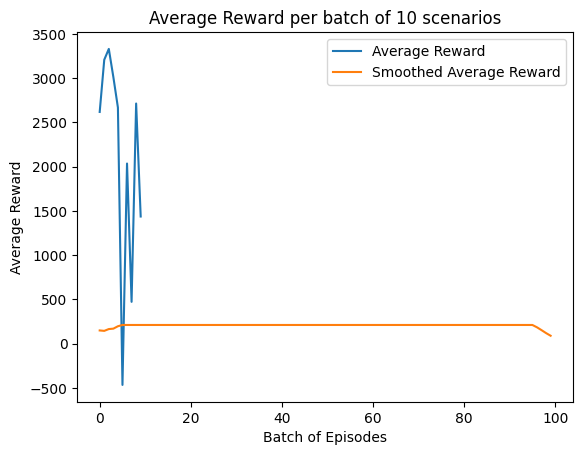

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated input
num_days_trained_on = len(training_folders) 
print(f"num_days_trained_on {len(training_folders)}")
rewards_per_day = len(rewards) // num_days_trained_on  

# Print out the structure of the rewards list
print(f"Trained on {num_days_trained_on} days of data ({len(training_folders)} unique scenarios)")

avg_rewards_per_batch = []

# amount of scenarios:
num_scenarios = len(training_folders)

# Average reward for every iteration of the scenarios
for i in range(0, len(rewards), len(training_folders)):
    avg_rewards_per_batch.append(np.mean([reward for _, _, reward in rewards[i:i+num_scenarios]]))

# Smooth the average rewards with trailing window
window = 100

# Compute trailing average
smoothed_avg_rewards_per_batch = np.convolve(avg_rewards_per_batch, np.ones(window)/window, mode='same')

# Print number of timesteps total
print(f"Total number of timesteps: {total_timesteps}")

# Create the new folder within results_dir
os.makedirs(os.path.join(results_dir, 'plots'), exist_ok=True)


# Plot the average rewards over the episodes
plt.plot(range(len(avg_rewards_per_batch)), avg_rewards_per_batch, label='Average Reward')
plt.plot(range(len(smoothed_avg_rewards_per_batch)), smoothed_avg_rewards_per_batch, label='Trailing Smoothed Average Reward')
plt.legend(['Average Reward', 'Smoothed Average Reward'])
plt.xlabel('Batch of Episodes')
plt.ylabel('Average Reward')
plt.title(f'Average Reward per batch of {num_scenarios} scenarios')
plt.savefig(os.path.join(results_dir, 'plots', 'rewards_per_batch.png'))
plt.show()


# print(avg_rewards_per_batch) 


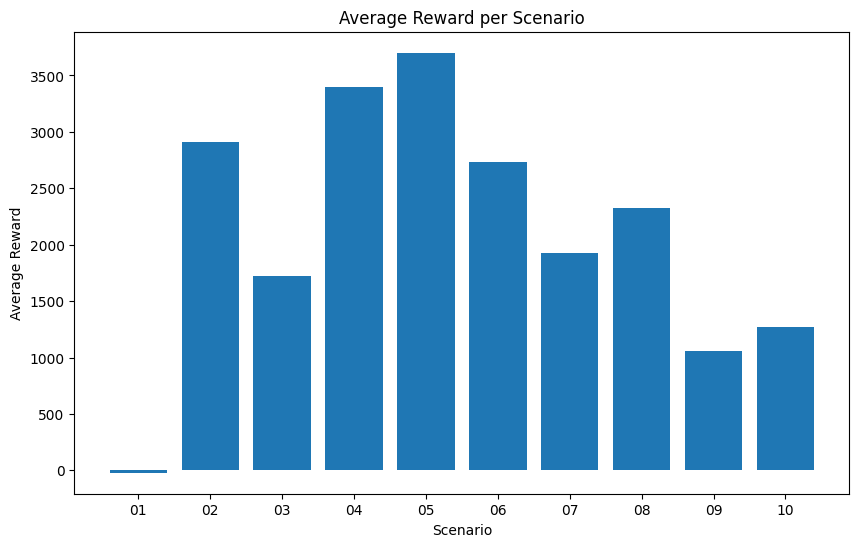

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize a dictionary to store rewards for each scenario
scenario_rewards = defaultdict(list)

# Iterate through the rewards list and group by scenario (last two characters)
for _, scenario, reward in rewards:
    scenario_id = scenario[-2:]  # Get the last two characters (e.g., '01', '02', etc.)
    scenario_rewards[scenario_id].append(reward)

# Now, calculate the average reward for each scenario
avg_rewards_per_batch_per_scenario = {scenario: np.mean(rewards) for scenario, rewards in scenario_rewards.items()}

# Sort the scenarios by their IDs (optional, to make sure they are ordered)
sorted_scenarios = sorted(avg_rewards_per_batch_per_scenario.keys())

# Extract the sorted average rewards
sorted_avg_rewards_per_batch = [avg_rewards_per_batch_per_scenario[scenario] for scenario in sorted_scenarios]

# Plot a bar chart with scenarios on the x-axis and average rewards on the y-axis
plt.figure(figsize=(10, 6))
plt.bar(sorted_scenarios, sorted_avg_rewards_per_batch)

# Adding labels and title
plt.xlabel('Scenario')
plt.ylabel('Average Reward')
plt.title('Average Reward per Scenario')
plt.savefig(os.path.join(results_dir, 'plots', 'average_reward_per_scenario.png'))


# Show plot
plt.show()


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create the new folder within results_dir
scenario_results_dir = os.path.join(results_dir, 'plots', 'reward-plots-per-scenario')
os.makedirs(scenario_results_dir, exist_ok=True)

# Iterate over all scenarios in scenario_rewards
for scenario_id, rewards_list in scenario_rewards.items():
    # Set the smoothing window (adjust the size as needed)
    window = 1000
    # Ensure the window size does not exceed the length of the rewards list
    if len(rewards_list) < window:
        window = len(rewards_list)
    smoothed_rewards = np.convolve(rewards_list, np.ones(window) / window, mode='same')

    plt.figure()
    plt.plot(rewards_list, label='Reward')
    plt.plot(smoothed_rewards, label='Smoothed Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward per Episode for Scenario ' + scenario_id)
    plt.legend()

    # Save the plot to the new folder
    plot_filename = f'average_reward_for_scenario_{scenario_id}.png'
    plt.savefig(os.path.join(scenario_results_dir, plot_filename))
    plt.close()

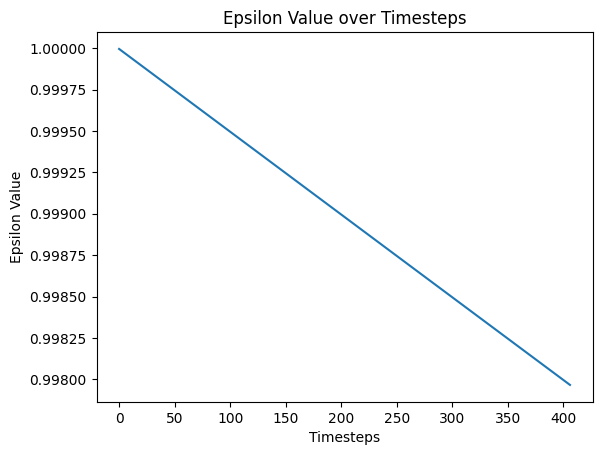

In [39]:

# Plot the epsilon values over the episodes
plt.plot(range(len(epsilon_values)), epsilon_values)
plt.xlabel('Timesteps')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Value over Timesteps')
plt.savefig(os.path.join(results_dir, 'plots', 'epsilon_value_over_timesteps.png'))

plt.show()

In [40]:
3

3